In [315]:
import sys
if '..' not in sys.path:
    sys.path.insert(0, '..')

import requests
import pandas as pd
import govcxanalyzer.data_preprocessing as dp
from govcxanalyzer import eda
from govcxanalyzer import utils
import govcxanalyzer.hypothesis_testing as ht
import numpy as np

tp = utils.get_date_timestamp()

print(tp)
import time

## in this notebook, we will apply nlp to the fake data
mergedcxdata =pd.read_csv("../data/mergedcxdata-2023-05-21.csv")
mergedcxdata = mergedcxdata.rename(columns={col: col.replace("attributes_", "") for col in list(mergedcxdata.columns)})

idcols = [col for col in mergedcxdata.columns if col.endswith("id")]
dp.make_categorical_subset(mergedcxdata).sample(2)



2023-08-28_03:56:17
Index(['type', 'organization_name', 'organization_abbreviation',
       'service_provider_name', 'collection_name', 'service_provided',
       'transaction_point', 'channel', 'omb_control_number',
       'federal_register_url', 'q1_text', 'q2_text', 'q3_text', 'q4_text',
       'q5_text', 'q6_text', 'q7_text', 'q8_text', 'q9_text', 'q10_text',
       'q11_text', 'created_at', 'updated_at', 'operational_metrics',
       'service_name', 'service_slug', 'service_desc',
       'service_provider_desc'],
      dtype='object')


,type,organization_name,organization_abbreviation,service_provider_name,collection_name,service_provided,transaction_point,channel,omb_control_number,federal_register_url,...,q9_text,q10_text,q11_text,created_at,updated_at,operational_metrics,service_name,service_slug,service_desc,service_provider_desc
130,omb_cx_reporting_collections,U.S. Department of Health & Human Services,HHS,Centers for Medicare and Medicaid Services,CX Quarterly Reporting,Online customer service and education for the ...,Survey displayed to website visitors upon exit...,computer,0938-1382,NaN,...,NaN,NaN,NaN,2021-07-07T22:54:55.132Z,2021-08-04T19:23:08.497Z,NaN,Asking About Medicare Benefits,hhs-medicare,Medicare is health insurance for people 65 or ...,1 in 4 Americans is covered by Medicaid (nearl...
301,omb_cx_reporting_collections,Department of Commerce,DOC,United States Patent and Trademark Office,CX Quarterly Reporting,U.S. Trademarks mobile website,Online survey,mobile,0690-0035,NaN,...,NaN,NaN,NaN,2022-07-12T16:19:04.416Z,2022-07-25T17:28:39.884Z,NaN,Filing an initial application form for a trade...,doc-trademarks,The Trademark organization intends to serve al...,The mission of the United States Patent and Tr...


In [302]:
## read in example hisp fake data


example_survey_df =pd.read_csv("../data/example-hisp-touchpoints-survey-drivers-cats.csv")

idcols =  ['ID', 'UUID']

additional_cols = ['Created At', "Page", "Referrer", "User Agent"]

drivers2questions = {
'Satisfaction': 'I am satisfied with the service I received from [service]',
 'Trust/Confidence': 'This interaction increased my confidence in [service provider]',
 'Effectiveness/Quality': 'My need was addressed.',
  'UserGroup': "Which best describes you?",
 "Years": "How many years have you been enrolled?",
 'Region': "Which region are you in?",
 'Ease/Simplicity': 'It was easy to complete what I needed to do.',
 'Efficiency/Speed': 'It took a reasonable amount of time to do what I needed to do.',
 'Equity/Transparency': "I understood what was being asked of me throughout the process.",
 'Helpfulness': 'The [service] helped me do what I needed to do.',
 "FreeText": "Please share any additional feedback you have about your experience with [service].",
 }



In [303]:


example_survey_df.sample(2)

,ID,UUID,Satisfaction,Trust/Confidence,Effectiveness/Quality,UserGroup,Years,Region,Ease/Simplicity,Efficiency/Speed,Equity/Transparency,Helpfulness,FreeText,Created At,Page,Referrer,User Agent
628,2023-08-27_17:35:06-629,df2e502c-aede-,4,4,4,Group4,3-4 years,Region4,4,3,3,3,NaN,2022-08-20 21:14:50 UTC,/contact/,https://beepbeep.gov/,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:1...
179,2023-08-27_17:35:06-180,84c93dbc-32c8-,4,4,4,Group4,2-3 years,Region3,3,3,3,3,NaN,2022-04-19 14:45:40 UTC,/contact/,https://catalog.beepbeep.gov/,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...


In [304]:
mergedcxdata[mergedcxdata["organization_abbreviation"]=="OPM"][['organization_abbreviation',
       'service_provider_name','service_provided',
       'transaction_point', 'channel', 
 'q1_text', 'q2_text', 'q3_text', 'q4_text',
       'q5_text', 'q6_text', 'q7_text', 'q8_text', 'created_at', 'updated_at', 'operational_metrics',
       'service_name', 'service_slug', 'service_desc',
       'service_provider_desc']].drop_duplicates().loc[5].to_dict()
 
 


{'organization_abbreviation': 'OPM',
 'service_provider_name': 'Federal Employment Services',
 'service_provided': 'USAJOBS Job Seeker Portal',
 'transaction_point': 'Visit three or more screens on the website',
 'channel': 'computer',
 'q1_text': 'I am satisfied with the service I received from USA JOBS.',
 'q2_text': 'This interaction increased my confidence in USA JOBS.',
 'q3_text': 'My need was addressed. ',
 'q4_text': 'It was easy to complete what I needed to do.',
 'q5_text': 'It took a reasonable amount of time to do what I needed to do.',
 'q6_text': 'I was easily able to access the website on my device.',
 'q7_text': 'The website helped me do what I needed to do.',
 'q8_text': nan,
 'created_at': '2021-05-14T06:26:51.372Z',
 'updated_at': '2021-08-04T19:48:20.440Z',
 'operational_metrics': nan,
 'service_name': 'Applying to Federal job opportunities',
 'service_slug': 'opm-fes',
 'service_desc': 'U.S. citizens seeking a Federal employment opportunity include students graduat


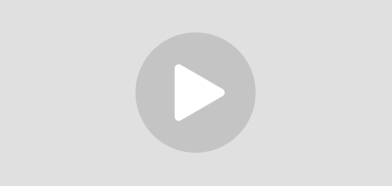
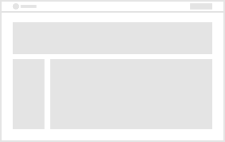
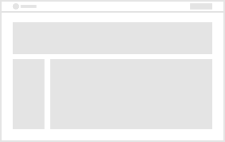

In [284]:

import requests
from bs4 import BeautifulSoup


base_url = "https://www.sitejabber.com/reviews/"

urls2get = ["usajobs.gov", "cdc.gov","ed.gov", "treasurydirect.gov"]

def get_soup_from_revies(url_):
    
    reviews = requests.get(url_)
    
    soup = BeautifulSoup(reviews.text)
    return soup

    
soupl = []

for ur_ in urls2get:
    soup = get_soup_from_revies(f"{base_url}{ur_}")
    
    soupl.append(soup)




<!DOCTYPE 
